In [1]:
%pip install --user pandas
import pandas as pd
import numpy as np

df = pd.read_excel(r"C:\Users\USUARIO\Desktop\quiniela origen.xlsx")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy as sp
import pickle
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
import itertools
from sklearn.model_selection import cross_val_score

In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix'); 
    

In [4]:
df.drop(['Temporada','Local', 'Visitante', 'V','V.1','E','E.1','D','D.1', 'Jornada', 'dif.', 'dif..1'], axis=1, inplace=True)

In [5]:
df= df.dropna(subset=['resultado'], axis=0)

In [6]:
df['Puntos Local']=pd.cut(df['PUNTOS'], bins=3, labels=['menos de 3', 'de 3 a 5', '6 o más'], right=False)
df['Puntos Visitante']=pd.cut(df['PUNTOS.1'], bins=3, labels=['menos de 3', 'de 3 a 5', '6 o más'], right=False)

In [7]:
df.drop(['PUNTOS', 'PUNTOS.1'], axis=1, inplace=True)

In [8]:
#df = df[df['cuartil']!=1]
#df.reset_index(drop=True)

In [9]:
df['GF_local'] = pd.qcut(df['AF'], q= [0, 0.3, 0.55, 1], labels = ['< 1', '1 - 1.411', '> 1.411'])
df['GC_local'] = pd.qcut(df['AC'], q= [0, 0.33, 0.75, 1], labels = ['< 0.929', '0.929 - 1.383', '> 1.383'])
#este es un elemento clave, decidir los intervalos de los goles a favor y en contra de local y visitante

In [10]:
df['GF_visitante'] = pd.qcut(df['AF.1'], q= [0, 0.3, 0.7, 1], labels = ['< 0.83', '0.83 - 1.2', '> 1.2'])
df['GC_visitante'] = pd.qcut(df['AC.1'], q= [0, 0.3, 0.55, 1], labels = ['< 1', '1 - 1.4', '> 1.4'])

In [11]:
df['desempeño_L'] = df['partidos consecutivos sin perder']-df['media de partidos sin ganar']
df['desempeño_V'] = df['partidos consecutivos sin perder.1']-df['media de partidos sin ganar.1']

In [12]:
df['resultado'] = df['resultado'].replace(1, 0)

In [13]:
df['resultado'] = df['resultado'].replace(2, 1)

In [14]:
df['racha_L'] = pd.qcut(df['desempeño_L'], q= [0, 0.6, 1], labels = ['< 0.15', '> 0.15'])
df['racha_V'] = pd.qcut(df['desempeño_V'], q= [0, 0.6, 1], labels = ['< 0.15', '> 0.15'])

In [15]:
df

,cuartil,partidos consecutivos sin perder,media de partidos sin ganar,último partido como local,último partido,AF,AC,cuartil.1,partidos consecutivos sin perder.1,media de partidos sin ganar.1,...,Puntos Local,Puntos Visitante,GF_local,GC_local,GF_visitante,GC_visitante,desempeño_L,desempeño_V,racha_L,racha_V
0,1,6.800000,1.333333,3,3,2.380000,0.25,2,4.142857,1.555556,...,6 o más,6 o más,> 1.411,< 0.929,0.83 - 1.2,< 1,5.466667,2.587302,> 0.15,> 0.15
1,1,6.800000,1.300000,0,3,1.480000,1.19,2,1.666667,3.625000,...,6 o más,menos de 3,> 1.411,0.929 - 1.383,< 0.83,> 1.4,5.500000,-1.958333,> 0.15,< 0.15
2,1,4.428571,1.555556,1,1,2.420000,1.08,4,2.000000,5.000000,...,6 o más,de 3 a 5,> 1.411,0.929 - 1.383,0.83 - 1.2,1 - 1.4,2.873016,-3.000000,> 0.15,< 0.15
3,3,2.400000,2.250000,3,3,1.380000,0.63,1,4.428571,1.555556,...,de 3 a 5,6 o más,1 - 1.411,< 0.929,> 1.2,< 1,0.150000,2.873016,< 0.15,> 0.15
4,3,2.555556,2.900000,0,0,1.640000,1.56,1,6.800000,1.333333,...,de 3 a 5,6 o más,> 1.411,> 1.383,> 1.2,< 1,-0.344444,5.466667,< 0.15,> 0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,4,1.800000,2.250000,1,3,0.666667,1.00,1,2.500000,1.400000,...,6 o más,de 3 a 5,< 1,0.929 - 1.383,> 1.2,< 1,-0.450000,1.100000,< 0.15,> 0.15
798,3,2.250000,2.250000,0,1,1.714286,1.00,2,2.500000,1.750000,...,menos de 3,de 3 a 5,> 1.411,0.929 - 1.383,0.83 - 1.2,< 1,0.000000,0.750000,< 0.15,> 0.15
799,1,6.000000,1.500000,1,0,2.333333,1.00,4,2.500000,4.000000,...,de 3 a 5,de 3 a 5,> 1.411,0.929 - 1.383,< 0.83,> 1.4,4.500000,-1.500000,> 0.15,< 0.15
800,3,2.000000,4.000000,1,1,1.333333,2.00,2,1.800000,2.000000,...,de 3 a 5,de 3 a 5,1 - 1.411,> 1.383,< 0.83,< 1,-2.000000,-0.200000,< 0.15,< 0.15


### Victoria local y empate **(NO PIERDE = 1)**, Victoria visitante **(PIERDE = 0)**

In [16]:
df.reset_index(drop=True, inplace=True)

In [17]:
Y = df['resultado'].to_numpy()
Y

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,

In [18]:
dummies =  pd.get_dummies(df[['GF_local', 'Puntos Visitante', 'GF_visitante', 'racha_L', 'racha_V', 'Puntos Local']])

In [19]:
#UPcL = pd.get_dummies(df['último partido como local'])
cuartil_V = pd.get_dummies(df['cuartil.1'])

In [20]:
df1 = pd.concat([dummies, cuartil_V], axis =1)

In [21]:
df1

,GF_local_< 1,GF_local_1 - 1.411,GF_local_> 1.411,Puntos Visitante_menos de 3,Puntos Visitante_de 3 a 5,Puntos Visitante_6 o más,GF_visitante_< 0.83,GF_visitante_0.83 - 1.2,GF_visitante_> 1.2,racha_L_< 0.15,racha_L_> 0.15,racha_V_< 0.15,racha_V_> 0.15,Puntos Local_menos de 3,Puntos Local_de 3 a 5,Puntos Local_6 o más,1,2,3,4
0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0
2,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0
4,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0
798,0,0,1,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0
799,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1
800,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0


df1.drop(['cuartil.1'], axis=1)

In [22]:
X = df1.to_numpy()
X

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [58]:
X_train, X_, Y_train, Y_ = train_test_split( X, Y, test_size=0.2, random_state=1234)
X_cv, X_test, Y_cv, Y_test = train_test_split( X_, Y_, test_size=0.5, random_state=42)

In [25]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [40]:
with open('RFC_1.pkl', 'rb') as fid:
    RFC_pickle = pickle.load(fid)

In [41]:
RFC_pickle

RandomForestClassifier(max_depth=11, max_features='sqrt', max_samples=59,
                       n_estimators=256)

In [56]:
RFC = RandomForestClassifier(max_features = 'sqrt', max_samples = 29, n_estimators = 256, max_depth = 11)
RFC.fit(X_train, Y_train)

RandomForestClassifier(max_depth=11, max_features='sqrt', max_samples=29,
                       n_estimators=256)

In [57]:
print (RFC.score(X_cv, Y_cv),'\n',RFC.score(X_test, Y_test))

0.8125 
 0.8148148148148148


In [91]:
yhat_cv = RFC.predict(X_cv)

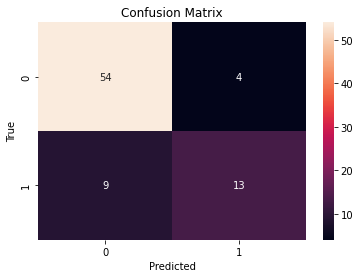

In [92]:
plot_confusion_matrix(Y_cv,yhat_cv)

In [93]:
print(classification_report(Y_cv, yhat_cv))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        58
           1       0.76      0.59      0.67        22

    accuracy                           0.84        80
   macro avg       0.81      0.76      0.78        80
weighted avg       0.83      0.84      0.83        80



In [94]:
yhat_test = RFC.predict(X_test)

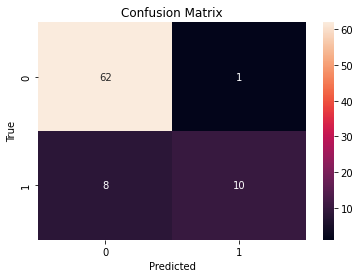

In [95]:
plot_confusion_matrix(Y_test,yhat_test)

In [96]:
print(classification_report(Y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        63
           1       0.91      0.56      0.69        18

    accuracy                           0.89        81
   macro avg       0.90      0.77      0.81        81
weighted avg       0.89      0.89      0.88        81



In [73]:
cv_scores = []
test_scores = []
ies=[]
for i in range(200):
    v = np.random.randint(1, 10000+1)
    RFCl = RandomForestClassifier(max_features = 'sqrt', max_samples = 59, n_estimators = 128, max_depth = 11, random_state=v)
    RFCl.fit(X_train, Y_train)
    cv_score = RFCl.score(X_cv, Y_cv)
    test_score = RFCl.score(X_test, Y_test)
    ies.append(v)
    cv_scores.append(cv_score)
    test_scores.append(test_score)

In [74]:
zips = tuple(zip(ies, cv_scores, test_scores))
zips

((8069, 0.8125, 0.8271604938271605),
 (6434, 0.8125, 0.8765432098765432),
 (9666, 0.8, 0.8641975308641975),
 (2969, 0.8, 0.7777777777777778),
 (1763, 0.8, 0.8148148148148148),
 (7206, 0.775, 0.8518518518518519),
 (824, 0.8125, 0.8518518518518519),
 (2525, 0.825, 0.8271604938271605),
 (6447, 0.7875, 0.8271604938271605),
 (1862, 0.825, 0.8271604938271605),
 (3665, 0.8, 0.8148148148148148),
 (7299, 0.8125, 0.8395061728395061),
 (1224, 0.8125, 0.8518518518518519),
 (7523, 0.8125, 0.8395061728395061),
 (3158, 0.8, 0.8395061728395061),
 (3024, 0.7875, 0.8395061728395061),
 (480, 0.7875, 0.8641975308641975),
 (8841, 0.8125, 0.8395061728395061),
 (6485, 0.8, 0.8518518518518519),
 (6014, 0.7875, 0.8271604938271605),
 (3515, 0.775, 0.8641975308641975),
 (2899, 0.8, 0.8148148148148148),
 (4739, 0.8125, 0.8395061728395061),
 (625, 0.7875, 0.8271604938271605),
 (1935, 0.8, 0.8641975308641975),
 (4929, 0.8125, 0.8271604938271605),
 (98, 0.7875, 0.8395061728395061),
 (314, 0.7875, 0.8271604938271605)

In [63]:
RFC_pickle.score(X_cv, Y_cv)

0.825

In [64]:
RFC_pickle.score(X_test, Y_test)

0.9012345679012346